In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/comb_clean_pitcher.csv', index_col=False)

In [3]:
df.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - SL - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,SL,5,0,1,0,0,9.0 - FB - called,14.0 - SL - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - SL - ball,9.0 - FB - called,14.0 - SL - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - CH - ball,14.0 - CH - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,CH,5,0,1,0,0,3.0 - FB - foul,14.0 - CH - ball,14.0 - CH - ball,2-2


In [4]:
df_clean = df.drop(df[df['pitch_count']== '4-2'].index)

In [5]:
df_clean.dropna(axis=0, inplace=True)

In [6]:
X = df_clean.drop(columns=['player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_number'])
y = df_clean['pitch_type']

categorical_cols = ['stand', 'outs_when_up', 'times_faced', 'XBH',
       'large_score_dif', 'recent_pitch', 'second_recent_pitch',
       'third_recent_pitch', 'pitch_count']

In [7]:
X.columns

Index(['stand', 'outs_when_up', 'times_faced', 'XBH', 'large_score_dif',
       'recent_pitch', 'second_recent_pitch', 'third_recent_pitch',
       'pitch_count'],
      dtype='object')

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

In [9]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

# Split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
dc = DummyClassifier(strategy='most_frequent')

In [11]:
dc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [12]:
dc.score(X_test, y_test)

0.540991461927165

In [13]:
# Create a column transformer to apply encoding only to the categorical columns
preprocessor = ColumnTransformer(transformers=
                                 [('cat', ohe, [0, 1, 2, 3, 4, 5, 6, 7, 8])],
                                 remainder='passthrough')

In [14]:
preprocessor.fit(X_train)

preprocessor.transform(X_train).shape

(68866, 627)

In [15]:
preprocessor.transform(X_test).shape

(22956, 627)

In [16]:
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for the original unbalanced training data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [17]:
class_weight_dict

{'CB': 2.2058295964125563,
 'CH': 1.7690608302507194,
 'FB': 0.4591311536615286,
 'SL': 1.2447762273154508}

In [ ]:
# Initialize the Decision Tree Classifier with class weights
dt_classifier = DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42)

# Fit the classifier to the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Generate classification report
report_dt = classification_report(y_test, y_pred_dt)

report_dt

In [18]:
pipe = Pipeline([('ct', preprocessor), ('dt', DecisionTreeClassifier())])

In [19]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9954694624342927

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(pipe, X_train, y_train)

array([0.44177436, 0.44674363, 0.44427503, 0.44420243, 0.43614318])

In [22]:
grid = {'dt__max_depth': [None, 20, 40, 60, 80],
       'dt__class_weight': [None, 'balanced', {'CB': 1.7515736766809729,
 'CH': 1.41,
 'FB': 0.368087185268696,
 'SL': 0.9970276872964169}]}

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
gs_pipe = GridSearchCV(estimator=pipe, param_grid=grid, verbose=2, n_jobs=-1)
gs_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  75 | elapsed:  1.2min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__class_weight': [None, 'balanced',
                       

In [25]:
gs_pipe.best_params_

{'dt__class_weight': None, 'dt__max_depth': 20}

In [26]:
gs_pipe.best_score_

0.5372317642073239

In [27]:
gs_pipe.best_estimator_.score(X_train, y_train)

0.5806348560973484

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf_pipe is your trained GridSearchCV object
best_gs = gs_pipe.best_estimator_

# Extract feature importances
importances = best_gs.feature_importances_

# Convert the importances into a pandas Series
feature_importances = df_clean(importances, index=categorical_cols)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importances in RandomForest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

grid = {'dt__max_depth': [None, 20, 40, 60, 80, 100], 
        'dt__min_samples_split': [2, 3, 4, 5], 
        'dt__min_samples_leaf': [1, 2, 3, 4],
        'dt_min_impurity_decrease': [0, 1, 2, 3, 4]}

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf_pipe = Pipeline([('ct', preprocessor), ('rf', RandomForestClassifier())])

In [34]:
grid_search_rf = {'rf__max_depth': [None, 25, 35, 45, 60],
       'rf__class_weight': ['balanced', 'balanced_subsample', {'CB': 1.7515736766809729,
 'CH': 1.41,
 'FB': 0.368087185268696,
 'SL': 0.9970276872964169}]}

In [35]:
rf_pipe = GridSearchCV(estimator=rf_pipe, param_grid=grid_search_rf, verbose=3, n_jobs=-1)
rf_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  75 | elapsed:  3.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.4min finished


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample',
       

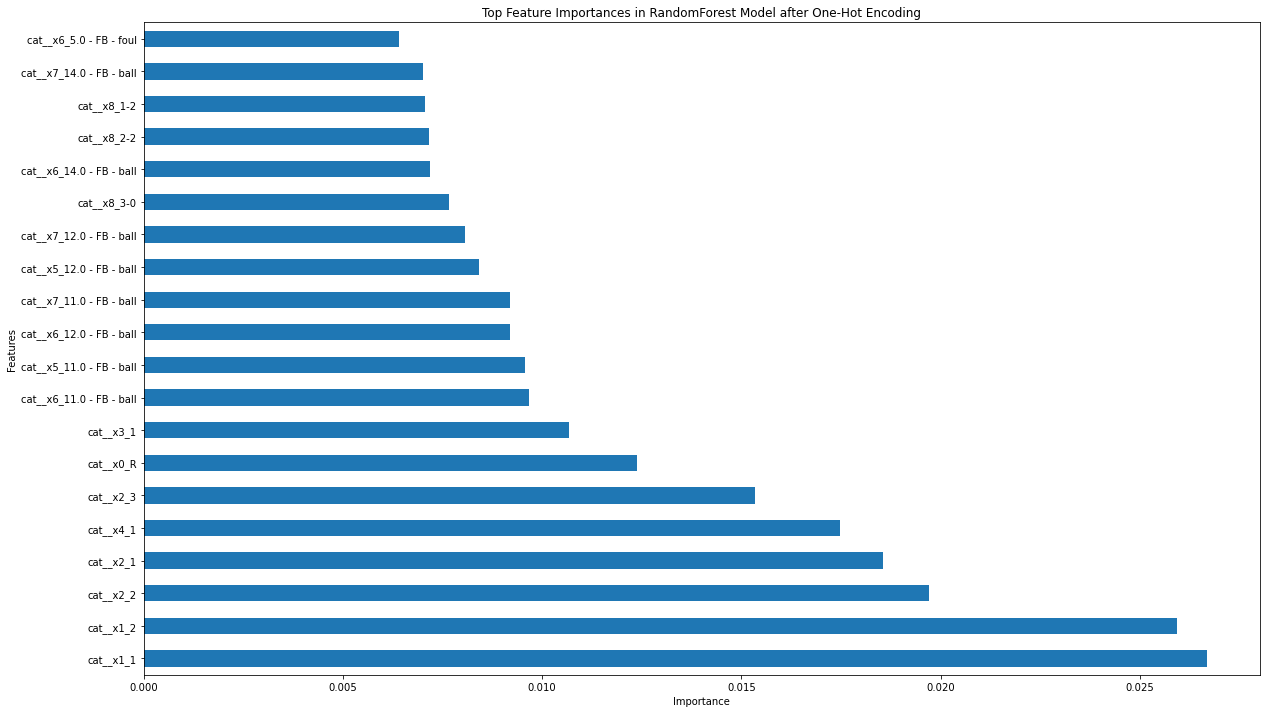

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf_pipe is your trained GridSearchCV object
best_rf = rf_pipe.best_estimator_

# Access the ColumnTransformer from the pipeline
# Replace 'preprocessor_name' with the actual name of your ColumnTransformer step
column_transformer = best_rf.named_steps['ct']

# Get the feature names after one-hot encoding and any 'passthrough' features
encoded_feature_names = column_transformer.get_feature_names()

# Extract feature importances
importances = best_rf.named_steps['rf'].feature_importances_

# Create a pandas Series with the importances and encoded feature names
feature_importances = pd.Series(importances, index=encoded_feature_names)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

n = 10  # for example, the top 20 features
top_sorted_importances = sorted_importances.head(N)

# Plot the feature importances
# Create a horizontal bar plot
plt.figure(figsize=(20,12))  # You may need to adjust the figure size to fit your screen
top_sorted_importances.plot(kind='barh')  # 'barh' creates a horizontal bar plot
plt.title('Top Feature Importances in RandomForest Model after One-Hot Encoding')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [48]:
print(rf_pipe.best_params_)
print(rf_pipe.best_score_)
print(rf_pipe.best_estimator_.score(X_train, y_train))

{'rf__class_weight': 'balanced_subsample', 'rf__max_depth': None}
0.5275026651038968
0.9953968576656115


In [ ]:
cross_val_score(rf_pipe, X_train, y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_pipe = Pipeline([('ct', preprocessor), ('gbc', GradientBoostingClassifier())])

In [ ]:
grid_gb = {
    'gbc__n_estimators': [50, 100],
    'gbc__learning_rate': [.001, .01, 0.1, 0.2],
    'gbc__max_depth': [None, 3, 4, 5, 6, 7]
}

In [ ]:
grid_search_pipe = GridSearchCV(estimator=gb_pipe, param_grid=grid_gb, verbose=3, n_jobs=8)
grid_search_pipe.fit(X_train, y_train)

In [ ]:
results = grid_search_pipe.cv_results_

In [ ]:
results

In [ ]:
grid_search_pipe.best_score_

In [ ]:
grid_search_pipe.best_params_

In [ ]:
grid_search_pipe.best_estimator_.score(X_train, y_train)

In [ ]:
gbc = GradientBoostingClassifier()
parameters = gbc.get_params()

In [ ]:
parameters